In [15]:
import json

with open("training_results.json") as f:
    training_results = json.load(f)

In [16]:
import pandas as pd
import json


def create_df_from_json(json_path):
    with open(json_path) as f:
        training_results = json.load(f)

    all_results = []

    for dataset, results in training_results.items():
        for algorithm in results:
            all_results.append(
                {
                    "dataset": dataset,
                    "model_name": algorithm,
                    "mean_bal_acc": results[algorithm].get("mean_bal_acc", None),
                    "std_dev_bal_acc": results[algorithm].get("std_dev_bal_acc", None),
                    "min": results[algorithm].get("min", None),
                    "max": results[algorithm].get("max", None),
                    "accuracies": results[algorithm].get("accuracies", None),
                    "n_iter": results[algorithm].get("n_iter", None),
                    "test_size": results[algorithm].get("test_size", None),
                    "train_costs": results[algorithm].get("train_costs", None),
                }
            )

    return pd.DataFrame(all_results)

# Iterations Comparison

In [ ]:
df = create_df_from_json("training_results.json")
df

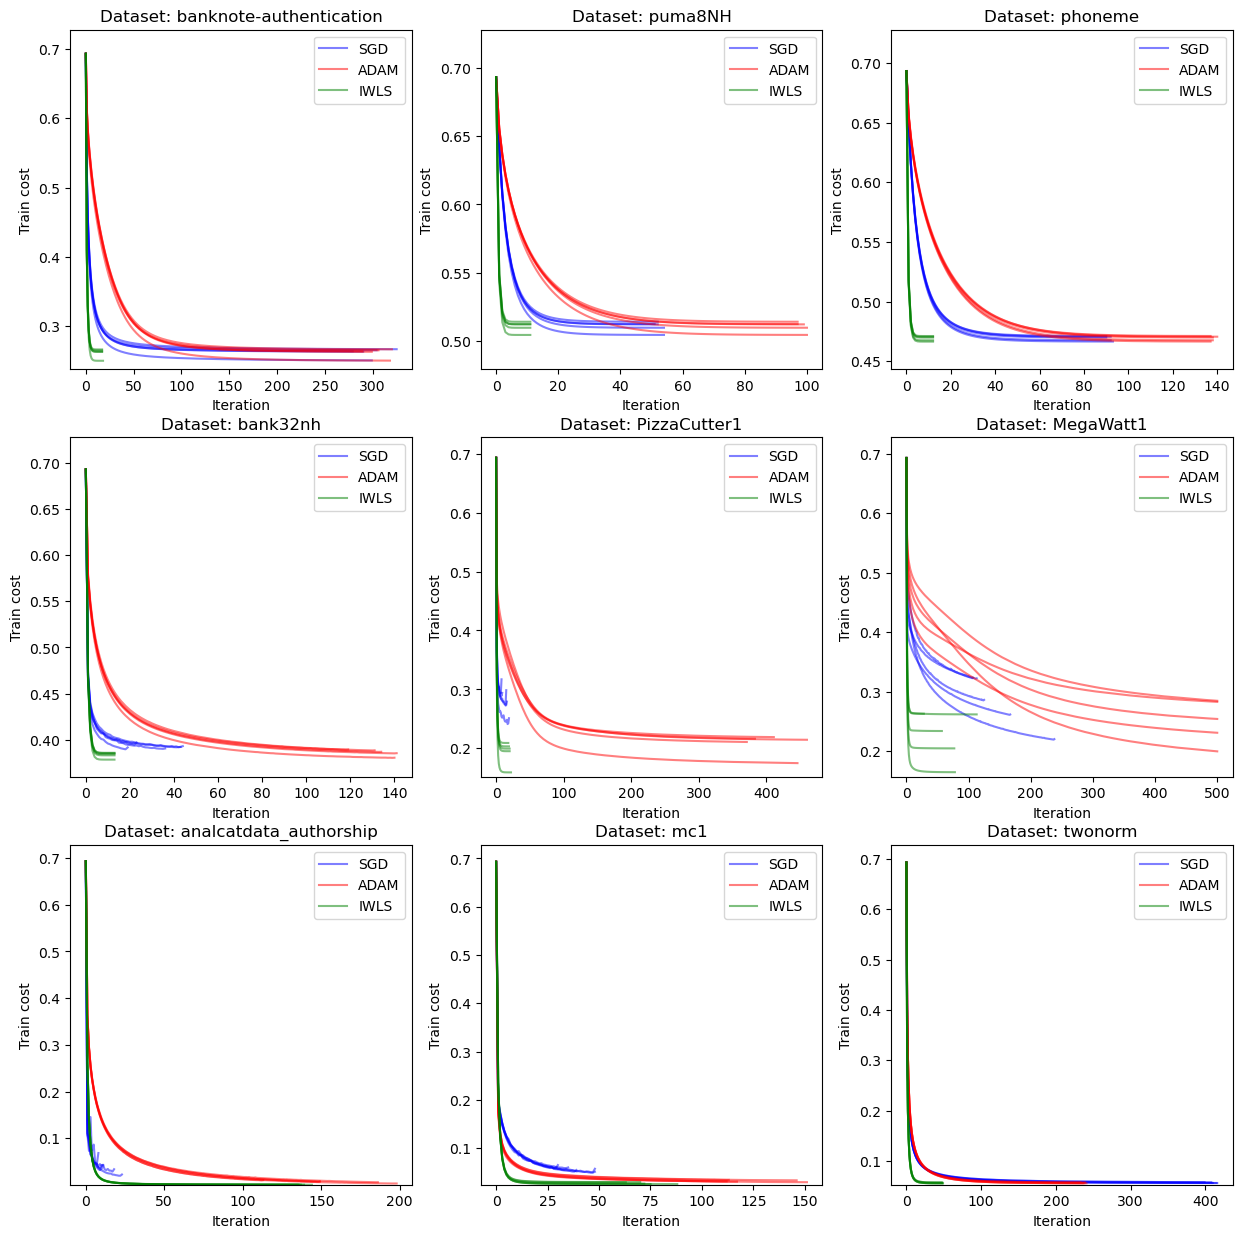

In [18]:
import matplotlib.pyplot as plt

colors = {"SGD": "blue", "ADAM": "red", "IWLS": "green"}

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, dataset in enumerate(df["dataset"].unique()):
    min_y = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: min([min(fold) for fold in x]))
        .min()
    )
    max_y = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: max([max(fold) for fold in x]))
        .max()
    )

    for model in df[df["dataset"] == dataset]["model_name"].unique():
        model_df = df[(df["dataset"] == dataset) & (df["model_name"] == model)]
        row = model_df.iloc[0]
        for j, train_costs in enumerate(row["train_costs"]):
            ax[i // 3, i % 3].plot(train_costs, label=model, color=colors[model], alpha=0.5)

    ax[i // 3, i % 3].set_title(f"Dataset: {dataset}")
    ax[i // 3, i % 3].set_xlabel("Iteration")
    ax[i // 3, i % 3].set_ylabel("Train cost")
    ax[i // 3, i % 3].set_ylim(max(0, min_y * 0.95), max_y * 1.05)

    # show only 1st, 6th and 11th element from legend
    handles, labels = ax[i // 3, i % 3].get_legend_handles_labels()
    ax[i // 3, i % 3].legend(handles[::5], labels[::5])


plt.savefig("plots/train_costs_9.png")
plt.show()


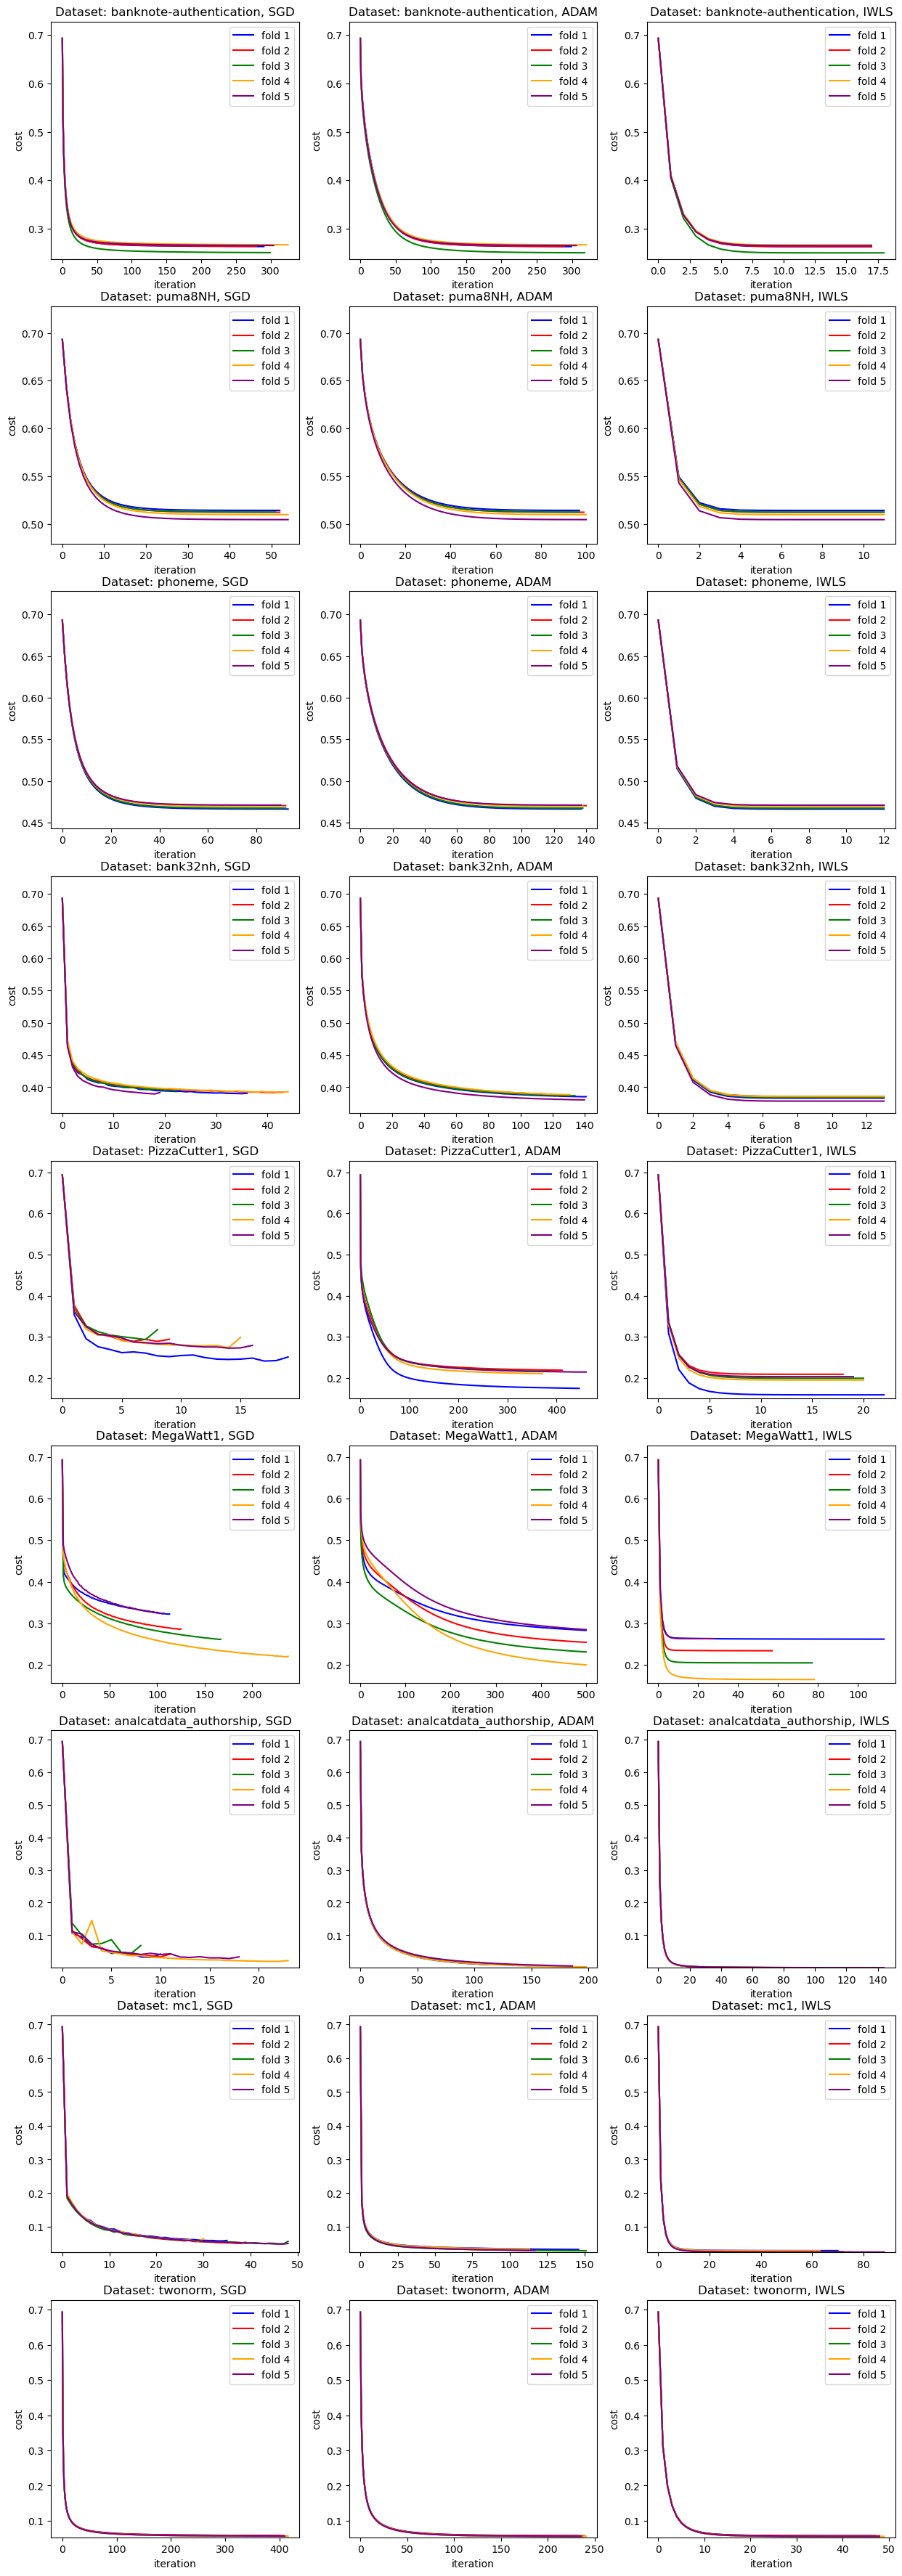

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(9, 3, figsize=(15, 45))

for i, dataset in enumerate(df["dataset"].unique()):
    min_y = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: min([min(fold) for fold in x]))
        .min()
    )
    max_y = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: max([max(fold) for fold in x]))
        .max()
    )

    for j, model in enumerate(df["model_name"].unique()):
        model_df = df[(df["dataset"] == dataset) & (df["model_name"] == model)]
        row = model_df.iloc[0]
        ax[i, j].plot(row["train_costs"][0], color="blue")
        ax[i, j].plot(row["train_costs"][1], color="red")
        ax[i, j].plot(row["train_costs"][2], color="green")
        ax[i, j].plot(row["train_costs"][3], color="orange")
        ax[i, j].plot(row["train_costs"][4], color="purple")
        ax[i, j].set_title(f"Dataset: {dataset}, {model}")
        ax[i, j].legend(["fold 1", "fold 2", "fold 3", "fold 4", "fold 5"])
        ax[i, j].set_ylim(max(0, min_y * 0.95), max_y * 1.05)
        ax[i, j].set_xlabel("iteration")
        ax[i, j].set_ylabel("cost")

plt.savefig("plots/train_costs_27.png")
plt.show()

# Compare classification methods

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from LogisticRegressors import SGD, ADAM, IWLS
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as bal_acc

import numpy as np

import json
import openml

from tqdm.notebook import tqdm

from utils import validate_datasets, preprocess_datasets

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import random

random.seed(42)
np.random.seed(42)

import copy

In [ ]:
with open("datasets.json", "r") as file:
    datasets = json.load(file)
datasets = preprocess_datasets(datasets, collinear_threshold=0.7)
validate_datasets(datasets)

In [22]:
from utils import performance_test

In [ ]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

result_dict = dict.fromkeys(datasets.keys(), dict())

for key in result_dict.keys():
    result_dict[key] = {
        "LDA": dict(),
        "QDA": dict(),
        "Decision_tree": dict(),
        "RF": dict(),
    }

for dataset in datasets.keys():

    print(f"Dataset: {dataset}")
    X, y = datasets[dataset]["X"], datasets[dataset]["y"]

    LDAs = [LinearDiscriminantAnalysis() for i in range(5)]
    QDAs = [
        QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True)
        for i in range(5)
    ]
    Decision_trees = [
        DecisionTreeClassifier(random_state=i, max_depth=2) for i in range(5)
    ]
    RFs = [RandomForestClassifier(random_state=i) for i in range(5)]
    x = {"LDA": LDAs, "QDA": QDAs, "Decision_tree": Decision_trees, "RF": RFs}
    for model_name, models in x.items():
        # print(f"Model: {model_name}")
        result_dict[dataset][model_name] = performance_test(
            X, y, models, model_name, test_size=0.2
        )

    with open("training_results_classifiers.json", "w") as file:
        json.dump(result_dict, file)

In [24]:
df = create_df_from_json("training_results.json")
classifiers_df = create_df_from_json("training_results_classifiers.json")

full_df = pd.concat([df, classifiers_df], axis=0)
full_df["model_name"] = full_df["model_name"].apply(
    lambda x: "Tree" if x == "Decision_tree" else x
)

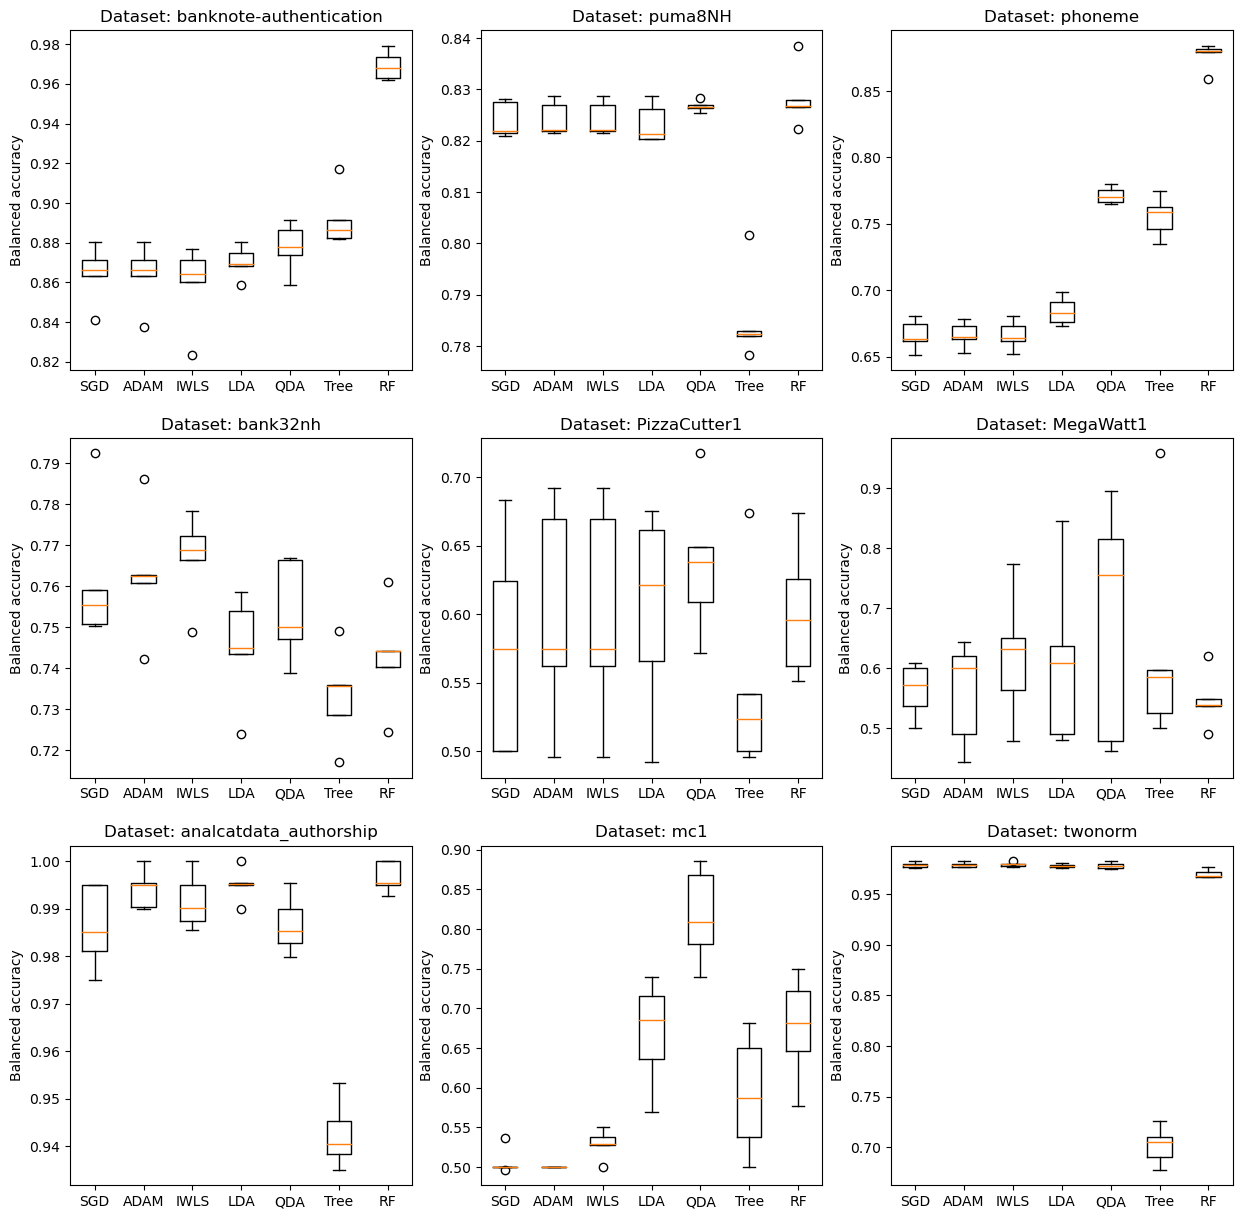

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, dataset in enumerate(full_df["dataset"].unique()):
    dataset_df = full_df[full_df["dataset"] == dataset]

    accuracies = dict(zip(dataset_df["model_name"], dataset_df["accuracies"]))
    ax[i // 3, i % 3].boxplot(accuracies.values(), labels=accuracies.keys())
    ax[i // 3, i % 3].set_title(f"Dataset: {dataset}")
    ax[i // 3, i % 3].set_ylabel("Balanced accuracy")


plt.savefig("plots/accuracies_9.png")
plt.show()

# Compare models with interactions and without

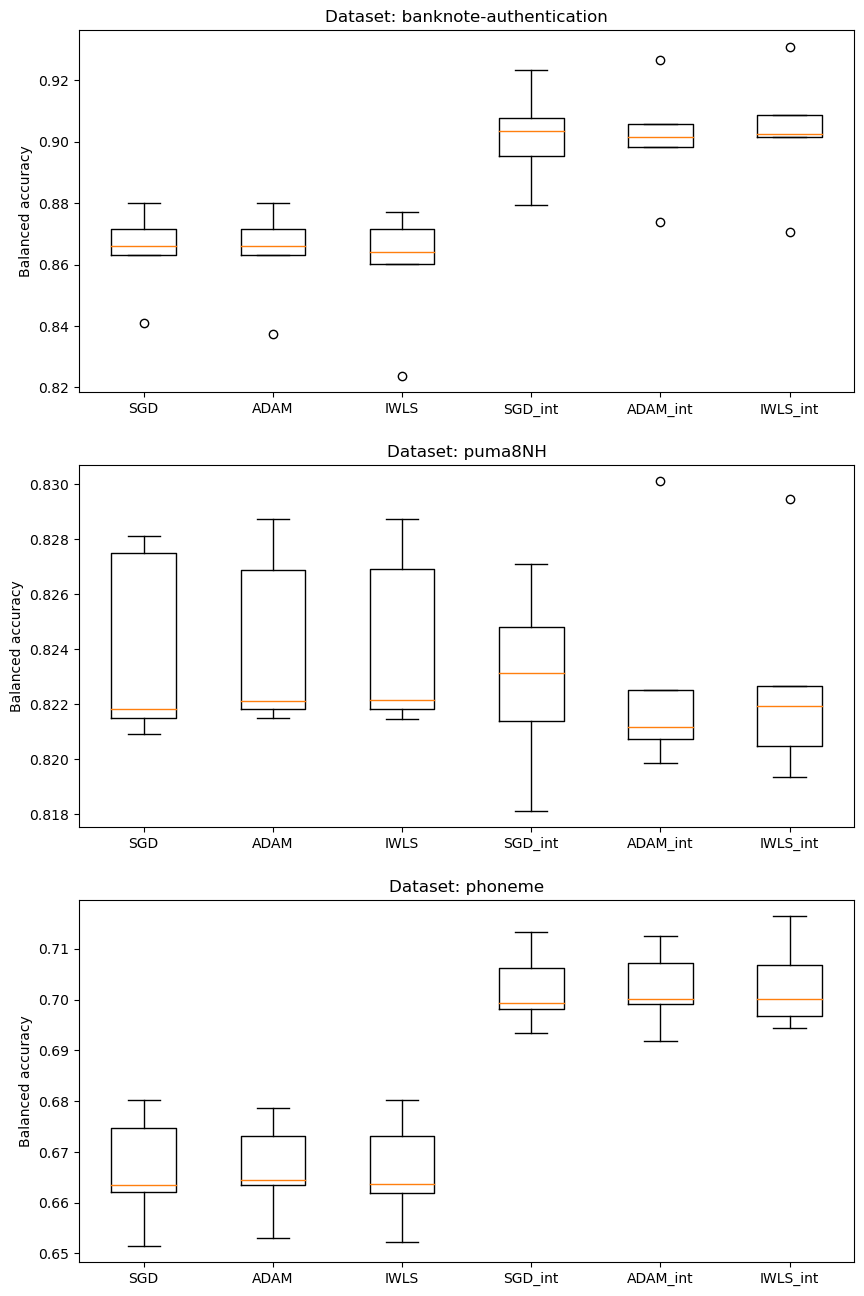

In [26]:
df = create_df_from_json("training_results.json")
interactions_df = create_df_from_json("training_results_interactions.json")

df["interactions"] = False
interactions_df["interactions"] = True
interactions_df = interactions_df[interactions_df["mean_bal_acc"].notnull()]
interactions_df["model_name"] = interactions_df["model_name"] + "_int"

datasets_small = interactions_df["dataset"].unique()
df = df[df["dataset"].isin(datasets_small)]

full_df = pd.concat([df, interactions_df], axis=0)
fig, ax = plt.subplots(3, 1, figsize=(10, 16))

for i, dataset in enumerate(full_df["dataset"].unique()):
    dataset_df = full_df[full_df["dataset"] == dataset]
    accuracies = dict(zip(dataset_df["model_name"], dataset_df["accuracies"]))
    ax[i].boxplot(accuracies.values(), labels=accuracies.keys())
    ax[i].set_title(f"Dataset: {dataset}")
    ax[i].set_ylabel("Balanced accuracy")

plt.savefig("plots/accuracies_interactions_3.png")
plt.show()



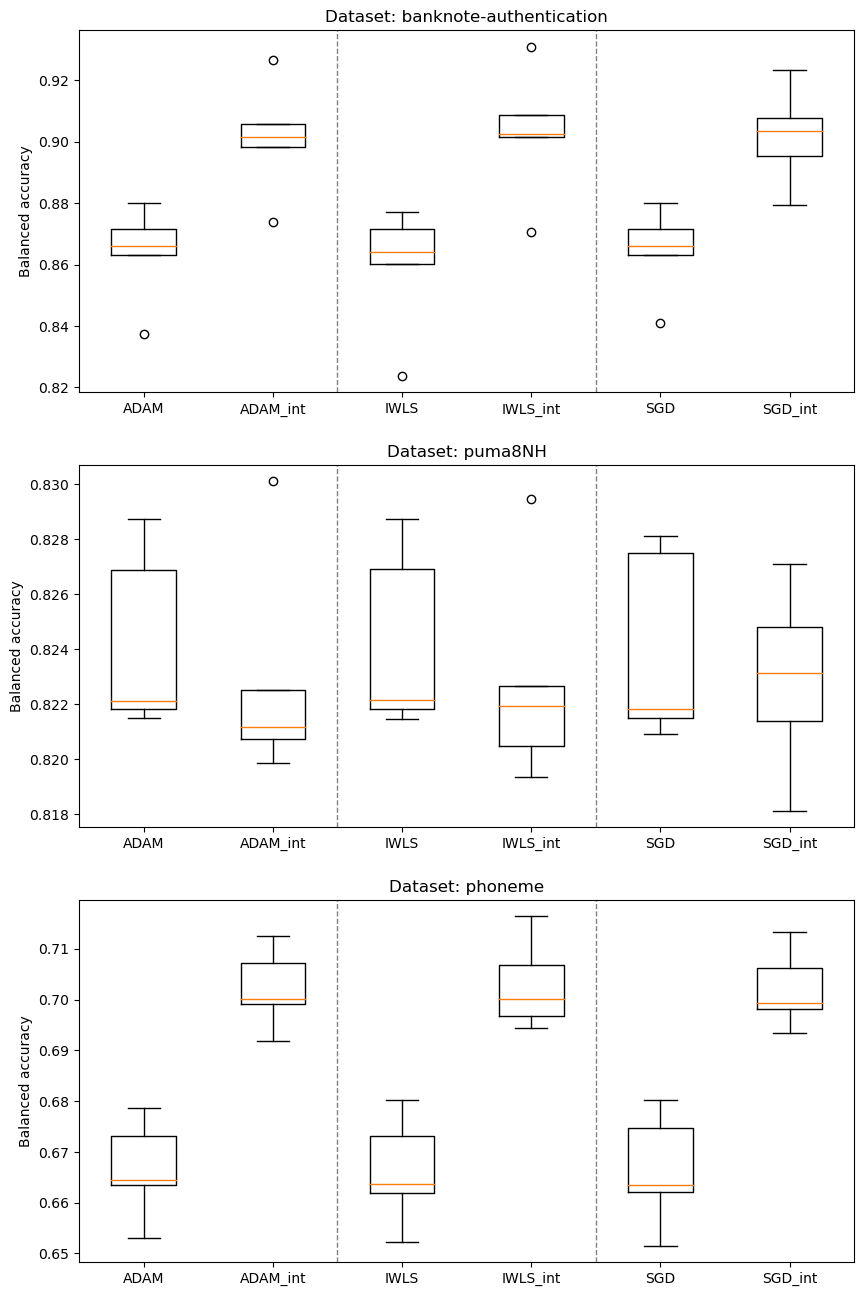

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(10, 16))

for i, dataset in enumerate(full_df["dataset"].unique()):
    dataset_df = full_df[full_df["dataset"] == dataset]
    dataset_df = dataset_df.sort_values("model_name")
    accuracies = dict(zip(dataset_df["model_name"], dataset_df["accuracies"]))
    ax[i].boxplot(accuracies.values(), labels=accuracies.keys())
    ax[i].set_title(f"Dataset: {dataset}")
    ax[i].set_ylabel("Balanced accuracy")
    for j in range(2, len(accuracies.keys()), 2):
        ax[i].axvline(j + 0.5, color="gray", linewidth=1, linestyle="--")

plt.savefig("plots/accuracies_interactions_3_Adam.png")
plt.show()

Dataset: banknote-authentication
Dataset: puma8NH
Dataset: phoneme


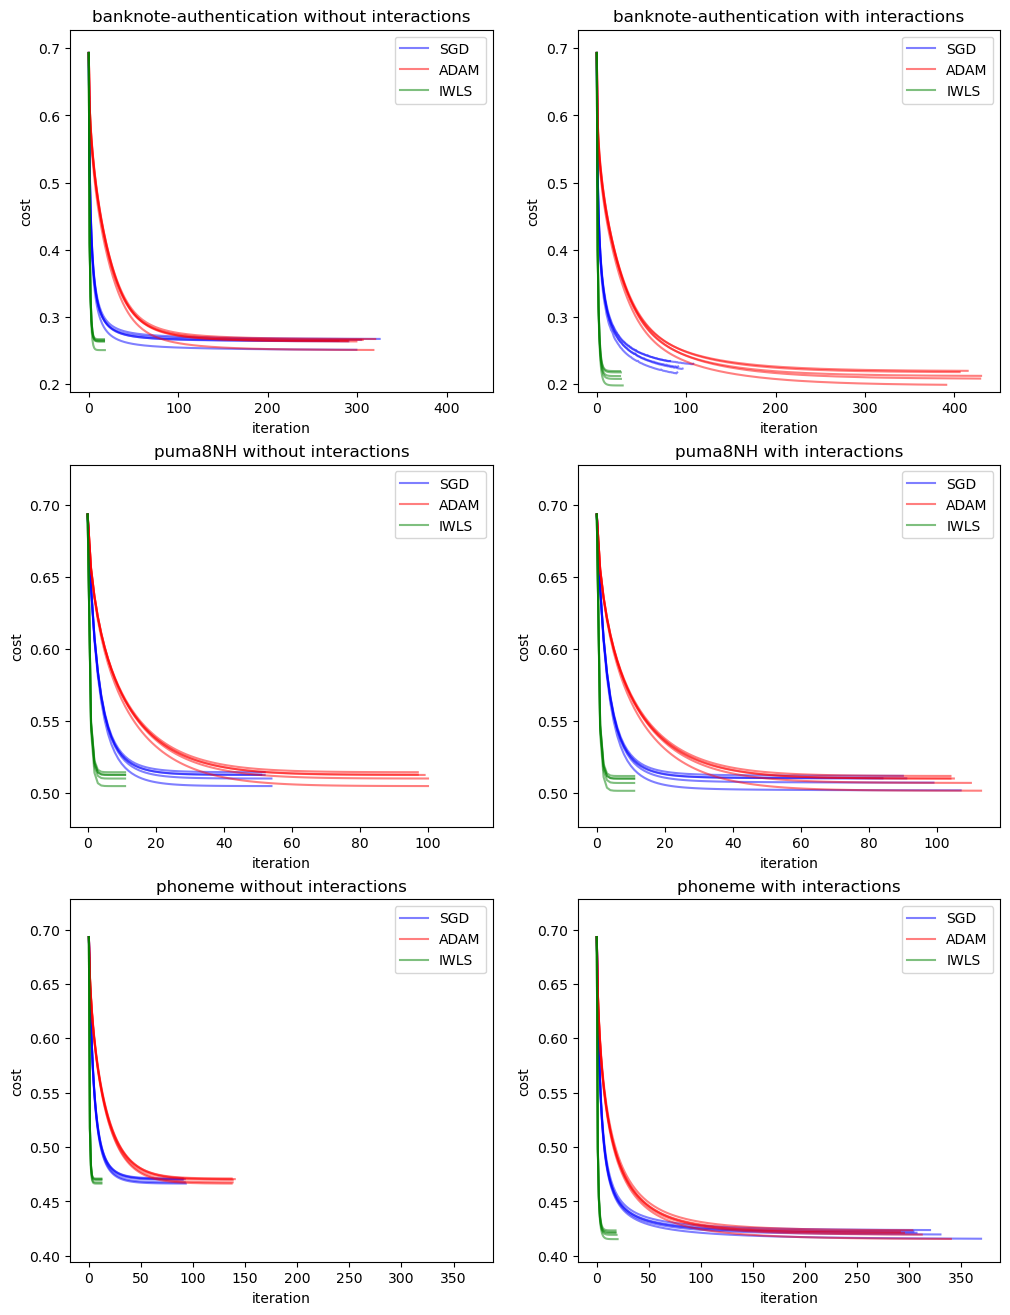

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(12, 16))

colors = {"SGD": "blue", "ADAM": "red", "IWLS": "green"}

for i, dataset in enumerate(df["dataset"].unique()):

    print(f"Dataset: {dataset}")

    # find min and max values for y axis
    min_y_wo_interactions = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: min([min(fold) for fold in x]))
        .min()
    )
    max_y_wo_interactions = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: max([max(fold) for fold in x]))
        .max()
    )

    min_y_interactions = (
        interactions_df[interactions_df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: min([min(fold) for fold in x]))
        .min()
    )
    max_y_interactions = (
        interactions_df[interactions_df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: max([max(fold) for fold in x]))
        .max()
    )

    # find min and max values for x axis
    min_x_wo_interactions = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: min([len(fold) for fold in x]))
        .min()
    )
    max_x_wo_interactions = (
        df[df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: max([len(fold) for fold in x]))
        .max()
    )

    min_x_interactions = (
        interactions_df[interactions_df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: min([len(fold) for fold in x]))
        .min()
    )
    max_x_interactions = (
        interactions_df[interactions_df["dataset"] == dataset]["train_costs"]
        .apply(lambda x: max([len(fold) for fold in x]))
        .max()
    )


    min_y = min(min_y_wo_interactions, min_y_interactions)
    max_y = max(max_y_wo_interactions, max_y_interactions)
    min_x = min(min_x_wo_interactions, min_x_interactions)
    max_x = max(max_x_wo_interactions, max_x_interactions)

    for j, model in enumerate(df["model_name"].unique()):

        # print(f"Model: {model}")
        model_df = df[(df["dataset"] == dataset) & (df["model_name"] == model)]
        row = model_df.iloc[0]

        for k, train_costs in enumerate(row["train_costs"]):
            ax[i, 0].plot(train_costs, label=model, color=colors[model], alpha = 0.5)
        ax[i, 0].set_title(f"{dataset} without interactions")
        ax[i, 0].set_ylim(max(0, min_y * 0.95), max_y * 1.05)

        padding = 0.05 * (max_x - min_x)
        ax[i, 0].set_xlim(0 - padding, max_x + padding)

        ax[i, 0].set_xlabel("iteration")
        ax[i, 0].set_ylabel("cost")

        handles, labels = ax[i, 0].get_legend_handles_labels()
        ax[i, 0].legend(handles[::5], labels[::5])

    for j, model in enumerate(df["model_name"].unique()):
        model_df = interactions_df[
            (interactions_df["dataset"] == dataset)
            & (interactions_df["model_name"] == model + "_int")
        ]
        row = model_df.iloc[0]
        for k, train_costs in enumerate(row["train_costs"]):
            ax[i, 1].plot(train_costs, label=model, color=colors[model], alpha = 0.5)
        ax[i, 1].set_title(f"{dataset} with interactions")
        ax[i, 1].set_ylim(max(0, min_y * 0.95), max_y * 1.05)
        
        padding = 0.05 * (max_x - min_x)
        ax[i, 0].set_xlim(0 - padding, max_x + padding)

        ax[i, 1].set_xlabel("iteration")
        ax[i, 1].set_ylabel("cost")

        handles, labels = ax[i, 1].get_legend_handles_labels()
        ax[i, 1].legend(handles[::5], labels[::5])

plt.savefig(f"plots/interactions_6.png")
plt.show()

